In [130]:
import numpy as np 
import pandas as pd
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim import SGD,  Adam
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import albumentations as A
import cv2
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [131]:
class FlowerDataset(Dataset):
    def __init__(self, transform = None, list_dir = None, label = None, threshold = None):
        self.data = []
        for dir in list_dir[:threshold]:
            img = cv2.imread(dir)
            img = transform(img)
            self.data.append([img, label])
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

libpng warning: iCCP: known incorrect sRGB profile


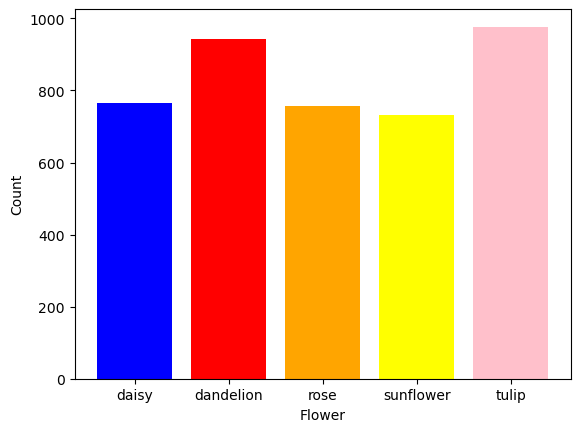

In [132]:
path_daisy = 'data/dataset_flower/training/daisy'
path_dandelion = 'data/dataset_flower/training/dandelion'
path_rose = 'data/dataset_flower/training/rose'
path_sunflower = 'data/dataset_flower/training/sunflower'
path_tulip = 'data/dataset_flower/training/tulip'

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)), transforms.Normalize((0.0, ), (1.0, ))])
dataset_daisy = FlowerDataset(transform = transform, label = 0, list_dir = list(paths.list_images(path_daisy)))
dataset_dandelion = FlowerDataset(transform = transform, label = 1, list_dir = list(paths.list_images(path_dandelion)))
dataset_rose = FlowerDataset(transform = transform, label = 2, list_dir = list(paths.list_images(path_rose)))
dataset_sunflower = FlowerDataset(transform = transform, label = 3, list_dir = list(paths.list_images(path_sunflower)))
dataset_tulip = FlowerDataset(transform = transform, label = 4, list_dir = list(paths.list_images(path_tulip)))
plt.bar(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 
        [dataset_daisy.__len__(), dataset_dandelion.__len__(), dataset_rose.__len__(), dataset_sunflower.__len__(), dataset_tulip.__len__()], 
        color = ['blue', 'red', 'orange', 'yellow', 'pink'])
plt.xlabel('Flower')
plt.ylabel('Count')
plt.show()

In [133]:
dataset_target = dataset_daisy.data + dataset_dandelion.data + dataset_rose.data + dataset_sunflower.data + dataset_tulip.data
print(len(dataset_target))
train_size = int(0.8 * dataset_target.__len__())
validation_size = len(dataset_target) - (train_size)
train_dataset, validation_dataset = random_split(dataset_target, [train_size, validation_size])
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

4175


In [134]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3))
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3))
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(128 * 6 * 6 , 512)
        self.linear2 = nn.Linear(512, 5)
        self.drop = nn.Dropout(p = 0.5)
        
    def forward(self, x):
        x = self.max_pool(self.activation(self.conv1(x)))
        x = self.drop(x)
        x = self.max_pool(self.activation(self.conv2(x)))
        x = self.drop(x)
        x = self.max_pool(self.activation(self.conv3(x)))
        x = self.drop(x)
        x = x.view(-1, 128 * 6 * 6)
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x

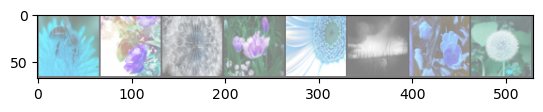

In [135]:
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(train_dataloader, 0):
    imshow(torchvision.utils.make_grid(images[:8])) 
    break

In [136]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [137]:
max_epochs = 100
train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    total = 0
    correct = 0
    for img, label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    
    # Evaluate model
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for img, label in validation_dataloader:
            outputs = model(img)
            loss = criterion(outputs, label)
            test_loss += loss.item()
            _, y_hat = torch.max(outputs, 1)
            total += label.size(0)
            correct += (y_hat == label).sum().item()
    test_loss /= len(validation_dataloader)
    test_losses.append(test_loss)
    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')
torch.save(model.state_dict(), 'model.pth')

Epoch 1/100, Train Loss: 1.5965, Test Loss: 1.6021, Test Accuracy: 0.2012
Epoch 2/100, Train Loss: 1.5520, Test Loss: 1.5639, Test Accuracy: 0.2671
Epoch 3/100, Train Loss: 1.4325, Test Loss: 1.4600, Test Accuracy: 0.3365
Epoch 4/100, Train Loss: 1.3141, Test Loss: 1.3337, Test Accuracy: 0.4275
Epoch 5/100, Train Loss: 1.2526, Test Loss: 1.3130, Test Accuracy: 0.4156
Epoch 6/100, Train Loss: 1.2119, Test Loss: 1.3319, Test Accuracy: 0.4120
Epoch 7/100, Train Loss: 1.2170, Test Loss: 1.2927, Test Accuracy: 0.4503
Epoch 8/100, Train Loss: 1.1857, Test Loss: 1.2902, Test Accuracy: 0.4371
Epoch 9/100, Train Loss: 1.1639, Test Loss: 1.2489, Test Accuracy: 0.4647
Epoch 10/100, Train Loss: 1.1587, Test Loss: 1.2780, Test Accuracy: 0.4479
Epoch 11/100, Train Loss: 1.1394, Test Loss: 1.2896, Test Accuracy: 0.4263
Epoch 12/100, Train Loss: 1.1210, Test Loss: 1.2690, Test Accuracy: 0.4311
Epoch 13/100, Train Loss: 1.1255, Test Loss: 1.2476, Test Accuracy: 0.4539
Epoch 14/100, Train Loss: 1.1116, 

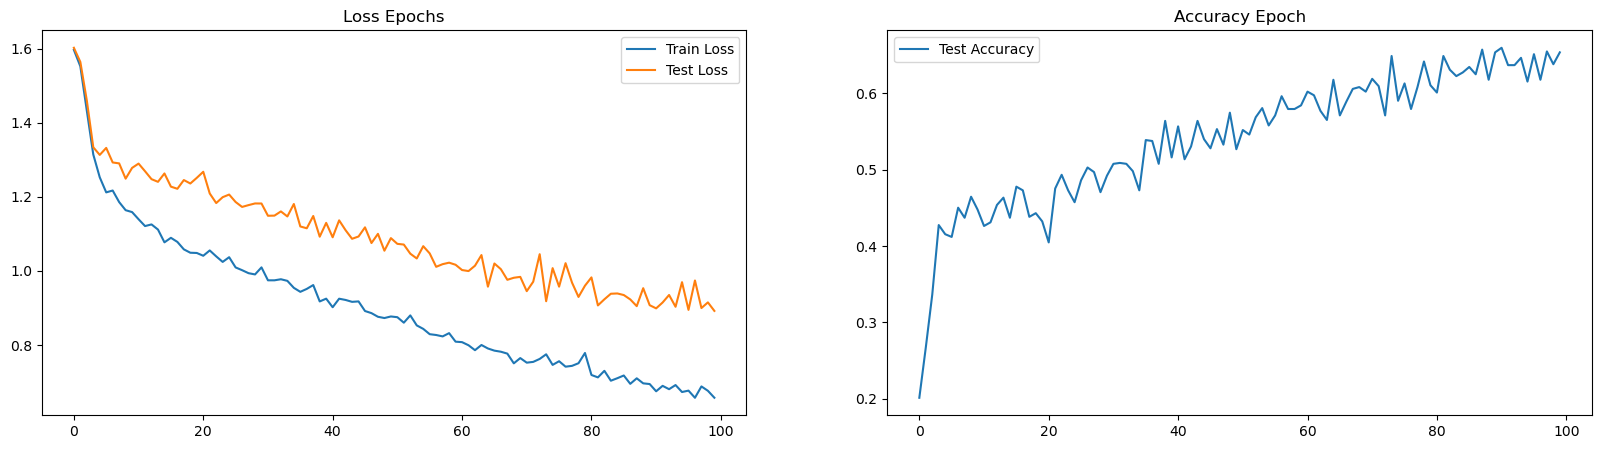

In [138]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')

plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()

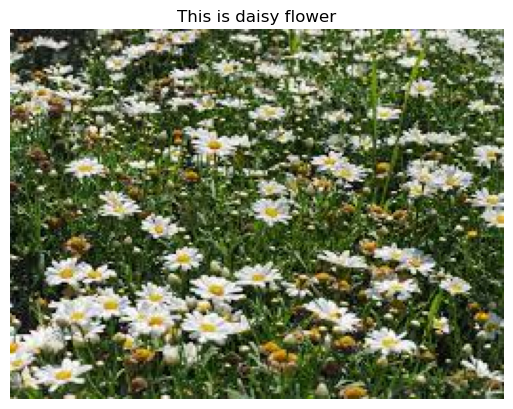

In [141]:
if __name__ == "__main__":
    path = input("Enter image path here: ")
    img = cv2.imread(path)
    new_img = transform(img)
    
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    with torch.no_grad():
        output = model(new_img)
        _, predicted = torch.max(output, 1)
    labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
    plt.title(f"This is {labels[predicted.item()]} flower")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()